In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json

folder_path = "/Users/Andy/Dropbox/git_repos/pae-amr-prediction/experiments/results/prediction"

output_path = "outputs/performance"

metric_cols = ['antimicrobial', 'model', 'auroc', 'f1', 'precision', 'recall']

In [2]:
from sklearn.metrics import f1_score

def get_performance(folder_path, 
                    antimicrobials, 
                    models,
                    metric='auroc',
                    binning_method='Dynamic'):

    performance_df = None
    for antimicrobial in antimicrobials.keys():
        for model in models.keys():
            tmp_fp = os.path.join(folder_path,
                                  f"result_{antimicrobial}_{model}.txt")
            if os.path.exists(tmp_fp):
                tmp_df = pd.read_csv(tmp_fp, header=0, delimiter='\t')

                # Add F1 macro
                prediction_fp = os.path.join(folder_path,
                                    f"result_{antimicrobial}_{model}.csv")
                if os.path.exists(prediction_fp):
                    prediction_df = pd.read_csv(prediction_fp, header=0)
                    f1_macro = np.round(f1_score(prediction_df['y_test'],
                                                 prediction_df['y_pred'],
                                                 average='macro'), 2)
                    tmp_df['f1_macro'] = f1_macro
                else:
                    tmp_df['f1_macro'] = -1
                tmp_df['antimicrobial'] = antimicrobial
                tmp_df['model'] = model
                cols = ['antimicrobial', 'model']
                cols.extend(tmp_df.columns[:-2])

                
                tmp_df = tmp_df.copy()[cols]
                if performance_df is None:
                    performance_df = tmp_df
                else:
                    performance_df = pd.concat([performance_df, tmp_df], 
                                            axis=0, 
                                            ignore_index=True)

    performance_df['antimicrobial'] = performance_df.apply(lambda row: antimicrobials[row['antimicrobial']], axis=1)
    performance_df['model'] = performance_df.apply(lambda row: models[row['model']], axis=1)
    performance_df['binning'] = binning_method

    performance_df.sort_values(by=['antimicrobial', 'model'], inplace=True, ascending=True)
    performance_df.reset_index(drop=True, inplace=True)

    best_idx = performance_df.groupby(['antimicrobial'])[metric].transform(max) == performance_df[metric]


    best_auc_df = performance_df.copy()[best_idx].reset_index(drop=True)

    best_auc_df = best_auc_df.sort_values(by=['antimicrobial','f1'], ascending=False).drop_duplicates(subset=['antimicrobial']).sort_values(by=['antimicrobial']).reset_index(drop=True)

    return performance_df, best_auc_df

In [3]:
antimicrobials = {"meropenem": "Meropenem", 
                  "amikacin": "Amikacin", 
                  "aztreonam": "Aztreonam", 
                  "ciprofloxacin": "Ciprofloxacin",
                  "piperacillin_tazobactam": "Piperacillin/tazobactam", 
                  "ceftolozane_tazobactam": "Ceftolozane/tazobactam",
                  "colistin": "Colistin", 
                  "tobramycin": "Tobramycin", 
                  "ceftazidime": "Ceftazidime",
                  "ceftazidime_avibactam": "Ceftazidime/avibactam", 
                  "imipenem": "Imipenem"}
models = {
    "LR": "Logistic Regression",
    "RF": "Random Forest",
    "SVM": "Support Vector Machine",
    "XGB": "XGBoost",
    "MLP": "Multilayer Perceptron"
}

In [4]:
dyn_100_folder_path = os.path.join(folder_path, 'dyn_100')

dyn_100_df, dyn_100_best_df = get_performance(dyn_100_folder_path,
                                              antimicrobials, 
                                              models,
                                              metric='auroc',
                                              binning_method='Dynamic binning')

dyn_100_best_df.to_csv(os.path.join(output_path, "dyn_100.csv"), index=False)
dyn_100_best_df

,antimicrobial,model,bacc,acc,auroc,f1,precision,recall,ll,tn,fn,tp,fp,threshold,f1_macro,binning
0,Amikacin,Multilayer Perceptron,0.75,0.84,0.91,0.67,1.00,0.50,0.39,52,12,12,0,0.589977,0.78,Dynamic binning
1,Aztreonam,Random Forest,0.66,0.78,0.64,0.48,0.57,0.42,0.55,51,11,8,6,0.296378,0.67,Dynamic binning
2,Ceftazidime,Multilayer Perceptron,0.70,0.75,0.76,0.60,0.88,0.45,0.63,43,17,14,2,0.699004,0.71,Dynamic binning
3,Ceftazidime/avibactam,Support Vector Machine,0.81,0.89,0.85,0.71,0.77,0.67,0.35,58,5,10,3,0.266631,0.82,Dynamic binning
4,Ceftolozane/tazobactam,Support Vector Machine,0.74,0.88,0.86,0.64,0.89,0.50,0.37,59,8,8,1,0.646466,0.78,Dynamic binning
5,Ciprofloxacin,Random Forest,0.74,0.80,0.83,0.86,0.80,0.94,0.51,14,3,47,12,0.414429,0.76,Dynamic binning
6,Colistin,Logistic Regression,0.50,0.93,0.63,0.00,0.00,0.00,0.26,71,5,0,0,0.039016,0.48,Dynamic binning
7,Imipenem,Support Vector Machine,0.72,0.72,0.77,0.72,0.69,0.75,0.57,28,9,27,12,0.536733,0.72,Dynamic binning
8,Meropenem,Support Vector Machine,0.69,0.80,0.77,0.55,0.90,0.39,0.50,52,14,9,1,0.420845,0.71,Dynamic binning
9,Piperacillin/tazobactam,XGBoost,0.67,0.71,0.71,0.54,0.81,0.41,0.86,41,19,13,3,0.626102,0.67,Dynamic binning


In [5]:
bin_3Da_folder_path = os.path.join(folder_path, 'bin_3Da')

bin_3Da_df, bin_3Da_best_df = get_performance(bin_3Da_folder_path,
                                              antimicrobials, 
                                              models,
                                              metric='auroc',
                                              binning_method='3Da binning')

bin_3Da_best_df

,antimicrobial,model,bacc,acc,auroc,f1,precision,recall,ll,tn,fn,tp,fp,threshold,f1_macro,binning
0,Amikacin,Multilayer Perceptron,0.82,0.83,0.89,0.75,0.70,0.79,0.38,44,5,19,8,0.487385,0.81,3Da binning
1,Aztreonam,XGBoost,0.61,0.80,0.69,0.35,1.00,0.21,0.66,57,15,4,0,0.368966,0.62,3Da binning
2,Ceftazidime,Logistic Regression,0.69,0.71,0.72,0.62,0.67,0.58,0.61,36,13,18,9,0.441792,0.69,3Da binning
3,Ceftazidime/avibactam,XGBoost,0.73,0.88,0.83,0.61,0.88,0.47,0.48,60,8,7,1,0.363649,0.77,3Da binning
4,Ceftolozane/tazobactam,Multilayer Perceptron,0.73,0.87,0.81,0.62,0.80,0.50,0.43,58,8,8,2,0.589365,0.77,3Da binning
5,Ciprofloxacin,Random Forest,0.71,0.78,0.78,0.84,0.78,0.92,0.54,13,4,46,13,0.452392,0.72,3Da binning
6,Colistin,Logistic Regression,0.50,0.93,0.61,0.00,0.00,0.00,0.26,71,5,0,0,0.036201,0.48,3Da binning
7,Imipenem,Support Vector Machine,0.75,0.75,0.76,0.72,0.76,0.69,0.60,32,11,25,8,0.574383,0.75,3Da binning
8,Meropenem,XGBoost,0.66,0.76,0.72,0.50,0.69,0.39,0.80,49,14,9,4,0.253723,0.67,3Da binning
9,Piperacillin/tazobactam,XGBoost,0.69,0.72,0.70,0.59,0.79,0.47,0.63,40,17,15,4,0.491789,0.69,3Da binning


In [6]:
bin_20Da_folder_path = os.path.join(folder_path, 'bin_20Da')

bin_20Da_df, bin_20Da_best_df = get_performance(bin_20Da_folder_path,
                                              antimicrobials, 
                                              models,
                                              metric='auroc',
                                              binning_method='20Da binning')

bin_20Da_best_df

,antimicrobial,model,bacc,acc,auroc,f1,precision,recall,ll,tn,fn,tp,fp,threshold,f1_macro,binning
0,Amikacin,Random Forest,0.79,0.82,0.88,0.71,0.71,0.71,0.45,45,7,17,7,0.398097,0.79,20Da binning
1,Aztreonam,Random Forest,0.55,0.78,0.61,0.19,1.00,0.11,0.56,57,17,2,0,0.510025,0.53,20Da binning
2,Ceftazidime,Random Forest,0.71,0.74,0.75,0.64,0.72,0.58,0.59,38,13,18,7,0.445002,0.72,20Da binning
3,Ceftazidime/avibactam,Support Vector Machine,0.76,0.89,0.83,0.67,0.89,0.53,0.35,60,7,8,1,0.486015,0.80,20Da binning
4,Ceftolozane/tazobactam,Multilayer Perceptron,0.73,0.87,0.79,0.62,0.80,0.50,0.41,58,8,8,2,0.505736,0.77,20Da binning
5,Ciprofloxacin,Support Vector Machine,0.74,0.79,0.83,0.85,0.80,0.90,0.50,15,5,45,11,0.285197,0.75,20Da binning
6,Colistin,XGBoost,0.50,0.93,0.64,0.00,0.00,0.00,0.26,71,5,0,0,0.304372,0.48,20Da binning
7,Imipenem,Support Vector Machine,0.73,0.74,0.77,0.71,0.74,0.69,0.59,31,11,25,9,0.597146,0.74,20Da binning
8,Meropenem,Support Vector Machine,0.66,0.79,0.69,0.50,0.89,0.35,0.58,52,15,8,1,0.407393,0.68,20Da binning
9,Piperacillin/tazobactam,Multilayer Perceptron,0.73,0.71,0.71,0.71,0.61,0.84,0.65,27,5,27,17,0.268750,0.71,20Da binning


In [7]:
selected_cols = ['antimicrobial', 'auroc', 'f1', 'precision', 'recall']

tmp_df = dyn_100_best_df[selected_cols].merge(bin_3Da_best_df[selected_cols],
                                              how='inner',
                                              on='antimicrobial',
                                              suffixes=('_dynamic', '_3Da'))
tmp_df

,antimicrobial,auroc_dynamic,f1_dynamic,precision_dynamic,recall_dynamic,auroc_3Da,f1_3Da,precision_3Da,recall_3Da
0,Amikacin,0.91,0.67,1.00,0.50,0.89,0.75,0.70,0.79
1,Aztreonam,0.64,0.48,0.57,0.42,0.69,0.35,1.00,0.21
2,Ceftazidime,0.76,0.60,0.88,0.45,0.72,0.62,0.67,0.58
3,Ceftazidime/avibactam,0.85,0.71,0.77,0.67,0.83,0.61,0.88,0.47
4,Ceftolozane/tazobactam,0.86,0.64,0.89,0.50,0.81,0.62,0.80,0.50
5,Ciprofloxacin,0.83,0.86,0.80,0.94,0.78,0.84,0.78,0.92
6,Colistin,0.63,0.00,0.00,0.00,0.61,0.00,0.00,0.00
7,Imipenem,0.77,0.72,0.69,0.75,0.76,0.72,0.76,0.69
8,Meropenem,0.77,0.55,0.90,0.39,0.72,0.50,0.69,0.39
9,Piperacillin/tazobactam,0.71,0.54,0.81,0.41,0.70,0.59,0.79,0.47


In [8]:
selected_cols = ['antimicrobial', 'auroc', 'f1', 'precision', 'recall']

tmp_df = dyn_100_best_df[selected_cols].merge(bin_20Da_best_df[selected_cols],
                                              how='inner',
                                              on='antimicrobial',
                                              suffixes=('_dynamic', '_20Da'))
tmp_df

,antimicrobial,auroc_dynamic,f1_dynamic,precision_dynamic,recall_dynamic,auroc_20Da,f1_20Da,precision_20Da,recall_20Da
0,Amikacin,0.91,0.67,1.00,0.50,0.88,0.71,0.71,0.71
1,Aztreonam,0.64,0.48,0.57,0.42,0.61,0.19,1.00,0.11
2,Ceftazidime,0.76,0.60,0.88,0.45,0.75,0.64,0.72,0.58
3,Ceftazidime/avibactam,0.85,0.71,0.77,0.67,0.83,0.67,0.89,0.53
4,Ceftolozane/tazobactam,0.86,0.64,0.89,0.50,0.79,0.62,0.80,0.50
5,Ciprofloxacin,0.83,0.86,0.80,0.94,0.83,0.85,0.80,0.90
6,Colistin,0.63,0.00,0.00,0.00,0.64,0.00,0.00,0.00
7,Imipenem,0.77,0.72,0.69,0.75,0.77,0.71,0.74,0.69
8,Meropenem,0.77,0.55,0.90,0.39,0.69,0.50,0.89,0.35
9,Piperacillin/tazobactam,0.71,0.54,0.81,0.41,0.71,0.71,0.61,0.84


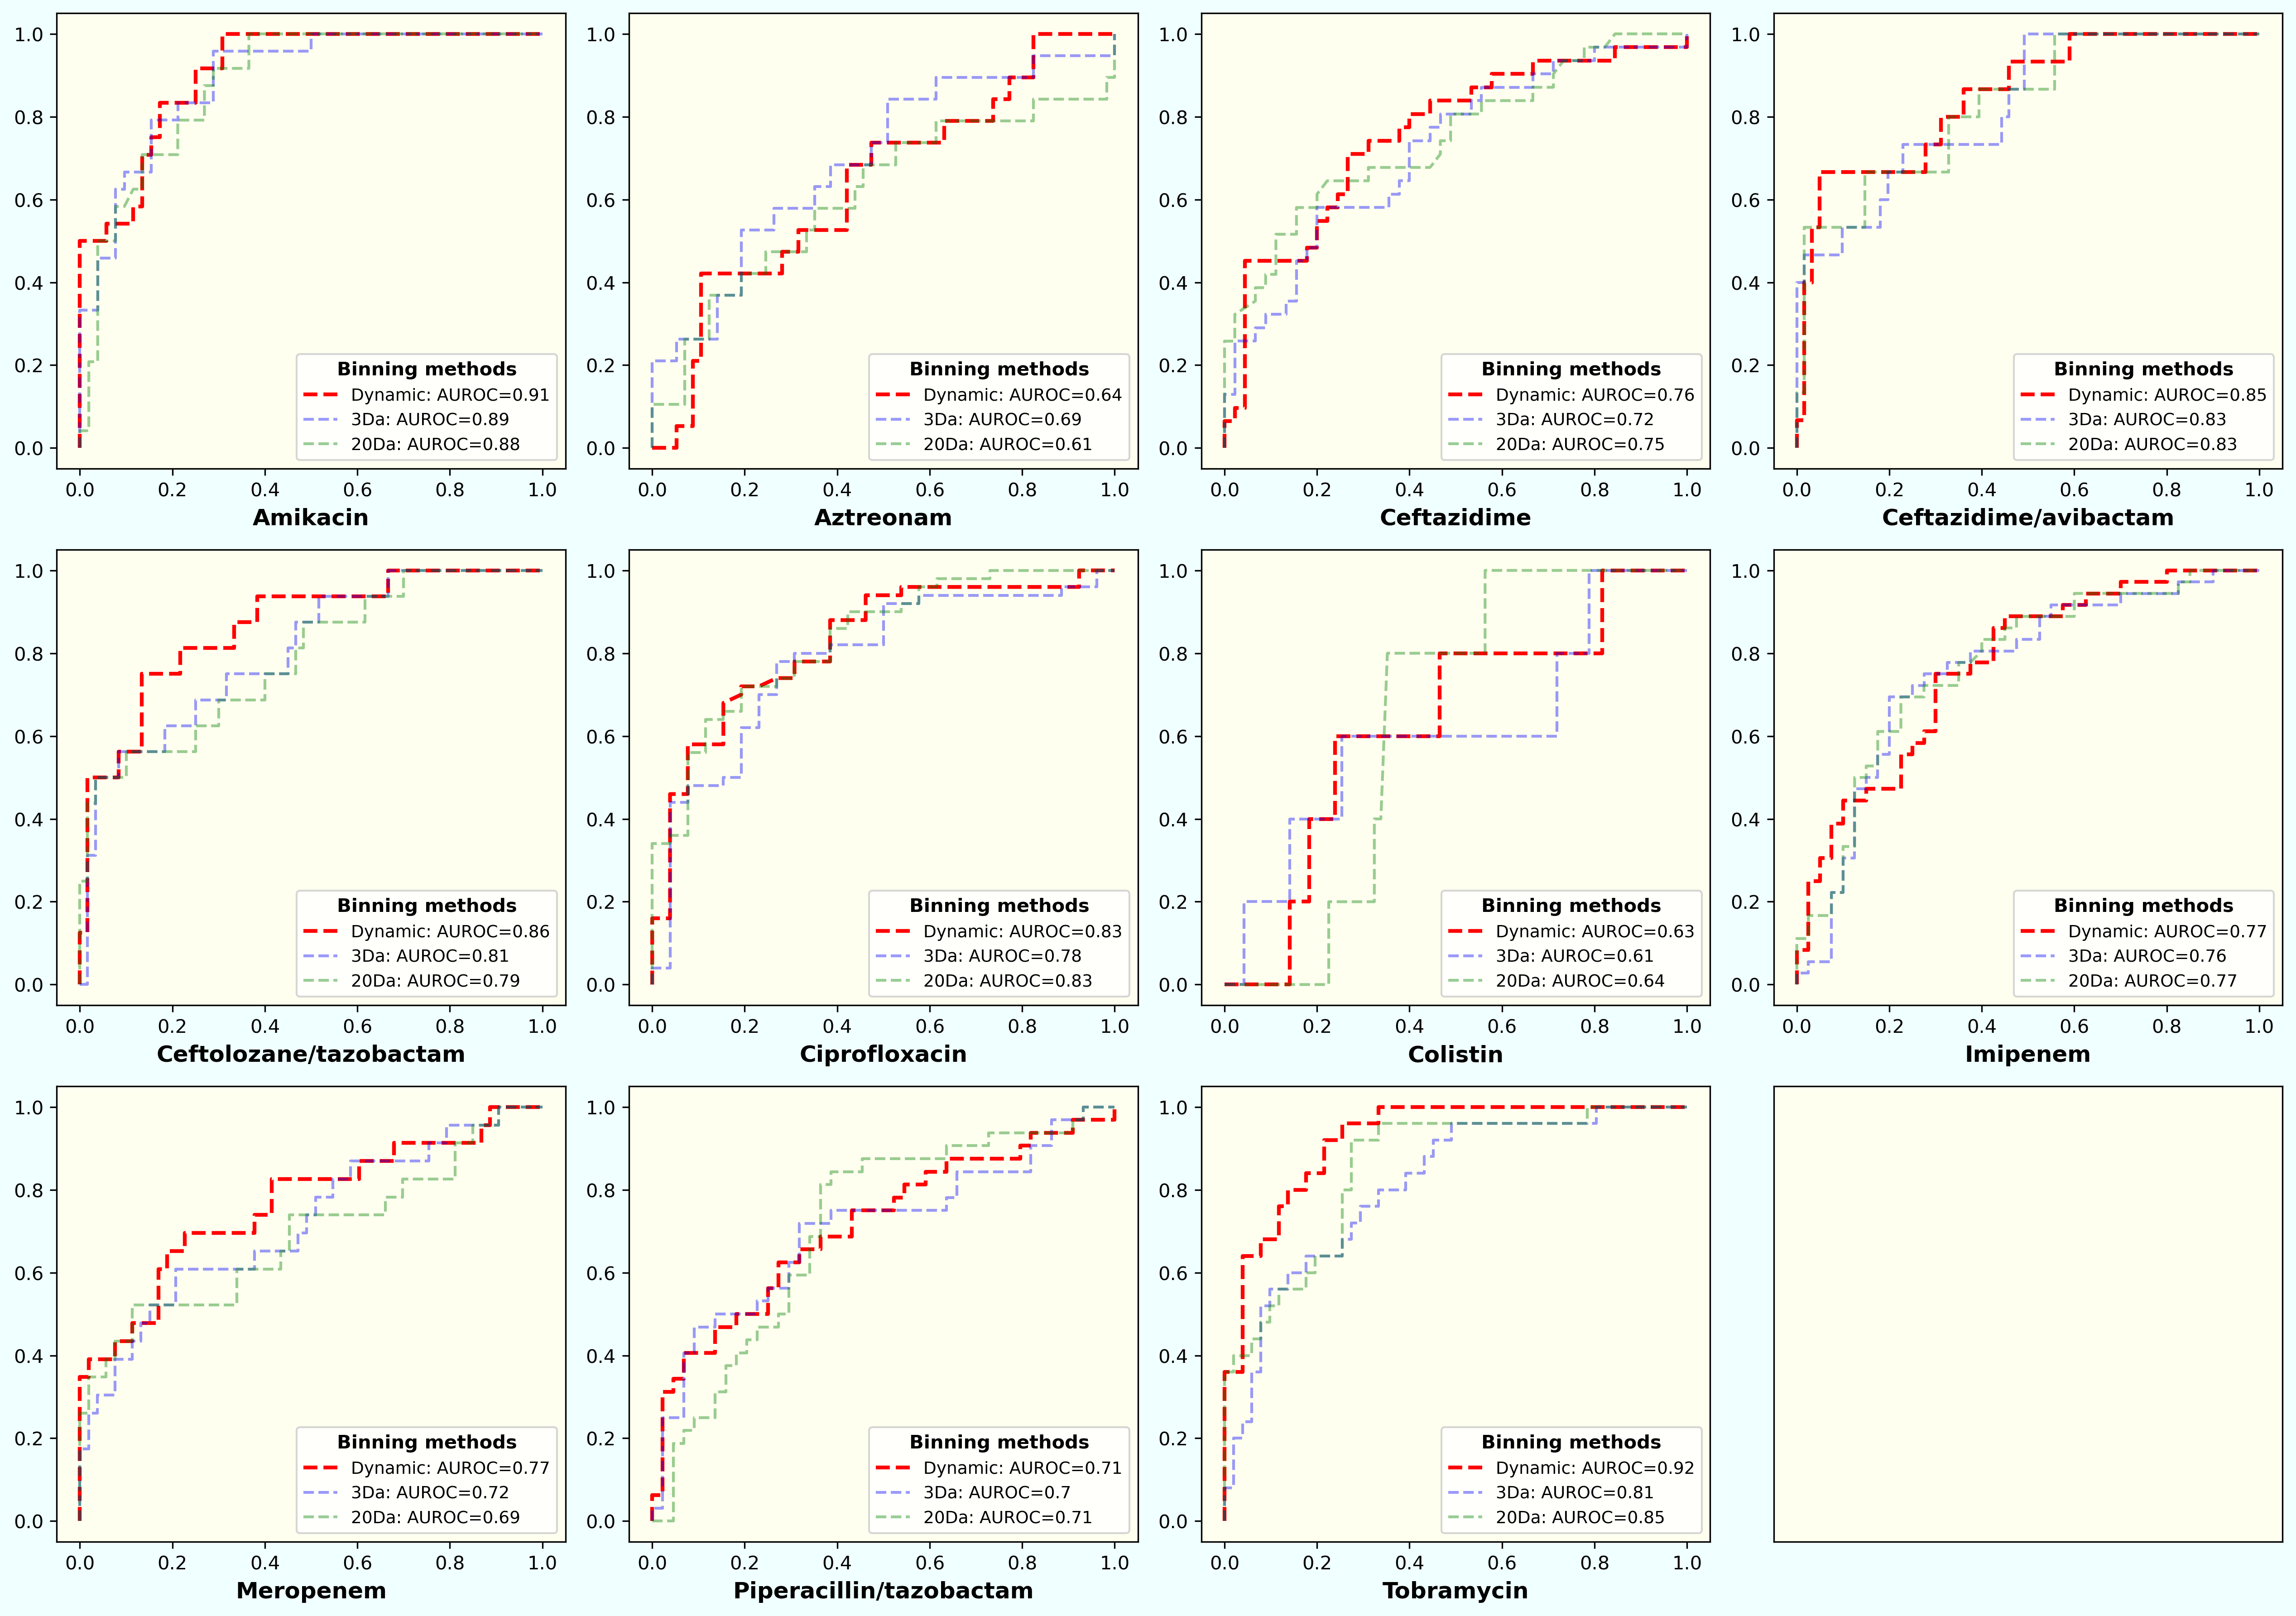

In [42]:
#Plotting
from sklearn.metrics import roc_curve, roc_auc_score, f1_score


tmp_df = pd.concat([dyn_100_best_df, bin_3Da_best_df, bin_20Da_best_df],
                   axis=0, ignore_index=True)

antimicrobials_r = {v: k for k, v in antimicrobials.items()}
models_r = {v: k for k, v in models.items()}

agents = sorted(antimicrobials.keys())

nrows = 3
ncols = 4
counter = 0

fig, ax = plt.subplots(nrows, ncols, figsize=(17, 12), dpi=300)

for row_id in range(nrows):
    for col_id in range(ncols):
        tmp_ax = ax[row_id, col_id]
        tmp_ax.set_facecolor('ivory')
        if counter == nrows * ncols  - 1:
            tmp_ax.set(xlabel=None, ylabel=None)
            tmp_ax.set_xticks([])
            tmp_ax.set_yticks([])
            break
        else:
            agent = agents[counter]
            tmp_ax.set_xlabel(antimicrobials[agent], 
                              fontsize=12,
                              fontweight='bold')

            dyn_100_model = tmp_df.copy()[(tmp_df['antimicrobial'] == antimicrobials[agent]) & (tmp_df['binning'] == 'Dynamic binning')]['model'].values[0]
            dyn_100_model = models_r[dyn_100_model]

            tmp_3Da_model = tmp_df.copy()[(tmp_df['antimicrobial'] == antimicrobials[agent]) & (tmp_df['binning'] == '3Da binning')]['model'].values[0]
            tmp_3Da_model = models_r[tmp_3Da_model]            

            tmp_20Da_model = tmp_df.copy()[(tmp_df['antimicrobial'] == antimicrobials[agent]) & (tmp_df['binning'] == '20Da binning')]['model'].values[0]
            tmp_20Da_model = models_r[tmp_20Da_model]

            # Dynamic binning curves
            tmp_dyn100_df = pd.read_csv(os.path.join(folder_path, "dyn_100", f"result_{agent}_{dyn_100_model}.csv"), header=0)[['y_test', 'y_proba', 'y_pred']]

            fpr, tpr, _ = roc_curve(tmp_dyn100_df["y_test"],
                                    tmp_dyn100_df["y_proba"])
            auroc = np.round(roc_auc_score(tmp_dyn100_df["y_test"],
                                        tmp_dyn100_df["y_proba"]), 2)
            f1 = np.round(f1_score(tmp_dyn100_df["y_test"],
                                   tmp_dyn100_df["y_pred"]), 2)

            tmp_ax.plot(fpr, 
                        tpr, 
                        color='red',
                        linestyle='--',
                        linewidth=2,
                        label=f"Dynamic: AUROC={auroc}", 
                        alpha=1)

            # 3Da binning curves
            tmp_3Da_df = pd.read_csv(os.path.join(folder_path, "bin_3Da", f"result_{agent}_{tmp_3Da_model}.csv"), header=0)[['y_test', 'y_proba', 'y_pred']]

            fpr, tpr, _ = roc_curve(tmp_3Da_df["y_test"],
                                    tmp_3Da_df["y_proba"])
            auroc = np.round(roc_auc_score(tmp_3Da_df["y_test"],
                                        tmp_3Da_df["y_proba"]), 2)
            f1 = np.round(f1_score(tmp_3Da_df["y_test"],
                                   tmp_3Da_df["y_pred"]), 2)

            tmp_ax.plot(fpr, 
                        tpr, 
                        color='blue',
                        linestyle='--',
                        label=f"3Da: AUROC={auroc}", 
                        alpha=0.4)

            # 30Da binning curves
            tmp_20Da_df = pd.read_csv(os.path.join(folder_path, "bin_20Da", f"result_{agent}_{tmp_20Da_model}.csv"), header=0)[['y_test', 'y_proba', 'y_pred']]

            fpr, tpr, _ = roc_curve(tmp_20Da_df["y_test"],
                                    tmp_20Da_df["y_proba"])
            auroc = np.round(roc_auc_score(tmp_20Da_df["y_test"],
                                        tmp_20Da_df["y_proba"]), 2)
            f1 = np.round(f1_score(tmp_20Da_df["y_test"],
                                   tmp_20Da_df["y_pred"]), 2)

            tmp_ax.plot(fpr, 
                        tpr, 
                        color='green',
                        linestyle='--',
                        label=f"20Da: AUROC={auroc}", 
                        alpha=0.4)

            tmp_ax.legend(loc='lower right', 
                          fontsize=9)  

            tmp_ax.get_legend().set_title("Binning methods",
                                          prop={"weight": "semibold"})              

        counter += 1

fig.patch.set_facecolor('azure')
plt.tight_layout()
plt.savefig("outputs/performance/auroc_plot_dyn_3Da_20Da.jpg", dpi=300)
# plt.show()

In [7]:
dyn_cluster_folder_path = os.path.join(folder_path, 'dyn_100_cluster')

dyn_cluster_df, dyn_cluster_best_df = get_performance(dyn_cluster_folder_path,
                                                      antimicrobials, 
                                                      models,
                                                      binning_method='dynamic')

dyn_cluster_best_df

,antimicrobial,model,bacc,acc,auroc,f1,precision,recall,ll,tn,fn,tp,fp,threshold,binning
0,Amikacin,XGBoost,0.82,0.82,0.83,0.82,0.82,0.82,0.62,31,7,31,7,0.561040,dynamic
1,Aztreonam,XGBoost,0.69,0.74,0.69,0.57,0.87,0.42,0.74,43,18,13,2,0.762593,dynamic
2,Ceftazidime,Multilayer Perceptron,0.59,0.62,0.61,0.69,0.66,0.73,0.78,14,12,33,17,0.343506,dynamic
3,Ceftazidime/avibactam,Support Vector Machine,0.71,0.82,0.76,0.59,0.77,0.48,0.49,52,11,10,3,0.368735,dynamic
4,Ceftolozane/tazobactam,Multilayer Perceptron,0.72,0.84,0.79,0.60,0.90,0.45,0.49,55,11,9,1,0.811654,dynamic
5,Ciprofloxacin,XGBoost,0.75,0.83,0.84,0.89,0.85,0.93,0.50,12,4,51,9,0.576247,dynamic
6,Colistin,Support Vector Machine,0.50,0.84,0.54,0.00,0.00,0.00,0.48,64,12,0,0,0.134913,dynamic
7,Imipenem,Support Vector Machine,0.72,0.74,0.79,0.79,0.76,0.82,0.58,19,8,37,12,0.586570,dynamic
8,Meropenem,Support Vector Machine,0.72,0.76,0.74,0.64,0.73,0.57,0.55,42,12,16,6,0.385905,dynamic
9,Piperacillin/tazobactam,Random Forest,0.62,0.64,0.65,0.73,0.63,0.86,0.65,13,6,36,21,0.435013,dynamic


In [8]:
selected_cols = ['antimicrobial', 'auroc', 'f1', 'precision', 'recall']

tmp_df = dyn_100_best_df[selected_cols].merge(dyn_cluster_best_df[selected_cols],
                                              how='inner',
                                              on='antimicrobial',
                                              suffixes=('_dyn', '_dyn_cluster'))

# tmp_df.to_csv(os.path.join(output_path, "dyn_100_vs_cluster.csv"), index=False)
tmp_df

,antimicrobial,auroc_dyn,f1_dyn,precision_dyn,recall_dyn,auroc_dyn_cluster,f1_dyn_cluster,precision_dyn_cluster,recall_dyn_cluster
0,Amikacin,0.83,0.79,0.78,0.82,0.83,0.82,0.82,0.82
1,Aztreonam,0.69,0.59,0.75,0.48,0.69,0.57,0.87,0.42
2,Ceftazidime,0.63,0.72,0.64,0.82,0.61,0.69,0.66,0.73
3,Ceftazidime/avibactam,0.78,0.61,0.83,0.48,0.76,0.59,0.77,0.48
4,Ceftolozane/tazobactam,0.75,0.65,0.79,0.55,0.79,0.60,0.90,0.45
5,Ciprofloxacin,0.83,0.90,0.84,0.96,0.84,0.89,0.85,0.93
6,Colistin,0.65,0.00,0.00,0.00,0.54,0.00,0.00,0.00
7,Imipenem,0.80,0.83,0.75,0.93,0.79,0.79,0.76,0.82
8,Meropenem,0.79,0.71,0.71,0.71,0.74,0.64,0.73,0.57
9,Piperacillin/tazobactam,0.67,0.72,0.68,0.76,0.65,0.73,0.63,0.86


In [9]:
dyn_smote_folder_path = os.path.join(folder_path, 'dyn_100_smote_whole')

dyn_smote_df, dyn_smote_best_df = get_performance(dyn_smote_folder_path,
                                                      antimicrobials, 
                                                      models,
                                                      binning_method='dynamic')


dyn_smote_best_df

,antimicrobial,model,bacc,acc,auroc,f1,precision,recall,ll,tn,fn,tp,fp,threshold,binning
0,Amikacin,Logistic Regression,0.70,0.70,0.72,0.75,0.64,0.92,0.69,18,3,35,20,4.978861e-01,dynamic
1,Aztreonam,Multilayer Perceptron,0.58,0.63,0.52,0.42,0.59,0.32,1.53,38,21,10,7,9.551843e-01,dynamic
2,Ceftazidime,Support Vector Machine,0.63,0.64,0.63,0.70,0.70,0.69,8.29,18,14,31,13,1.000000e-07,dynamic
3,Ceftazidime/avibactam,Multilayer Perceptron,0.72,0.79,0.69,0.60,0.63,0.57,0.79,48,9,12,7,7.169765e-01,dynamic
4,Ceftolozane/tazobactam,Logistic Regression,0.50,0.74,0.57,0.00,0.00,0.00,0.69,56,20,0,0,5.001292e-01,dynamic
5,Ciprofloxacin,Multilayer Perceptron,0.75,0.83,0.83,0.89,0.85,0.93,2.41,12,4,51,9,2.002002e-03,dynamic
6,Colistin,Logistic Regression,0.50,0.84,0.51,0.00,0.00,0.00,0.69,64,12,0,0,5.077299e-01,dynamic
7,Imipenem,Multilayer Perceptron,0.61,0.68,0.63,0.79,0.65,1.00,0.72,7,0,45,24,5.732994e-01,dynamic
8,Meropenem,Logistic Regression,0.63,0.67,0.60,0.51,0.57,0.46,0.69,38,15,13,10,4.999791e-01,dynamic
9,Piperacillin/tazobactam,Multilayer Perceptron,0.60,0.63,0.57,0.73,0.62,0.88,1.03,11,5,37,23,8.213230e-01,dynamic


In [10]:
selected_cols = ['antimicrobial', 'auroc', 'f1', 'precision', 'recall']

tmp_df = dyn_100_best_df[selected_cols].merge(dyn_smote_best_df[selected_cols],
                                              how='inner',
                                              on='antimicrobial',
                                              suffixes=('_dyn', '_dyn_smote'))

# tmp_df.to_csv(os.path.join(output_path, "dyn_100_vs_smote_whole.csv"), index=False)
tmp_df

,antimicrobial,auroc_dyn,f1_dyn,precision_dyn,recall_dyn,auroc_dyn_smote,f1_dyn_smote,precision_dyn_smote,recall_dyn_smote
0,Amikacin,0.83,0.79,0.78,0.82,0.72,0.75,0.64,0.92
1,Aztreonam,0.69,0.59,0.75,0.48,0.52,0.42,0.59,0.32
2,Ceftazidime,0.63,0.72,0.64,0.82,0.63,0.70,0.70,0.69
3,Ceftazidime/avibactam,0.78,0.61,0.83,0.48,0.69,0.60,0.63,0.57
4,Ceftolozane/tazobactam,0.75,0.65,0.79,0.55,0.57,0.00,0.00,0.00
5,Ciprofloxacin,0.83,0.90,0.84,0.96,0.83,0.89,0.85,0.93
6,Colistin,0.65,0.00,0.00,0.00,0.51,0.00,0.00,0.00
7,Imipenem,0.80,0.83,0.75,0.93,0.63,0.79,0.65,1.00
8,Meropenem,0.79,0.71,0.71,0.71,0.60,0.51,0.57,0.46
9,Piperacillin/tazobactam,0.67,0.72,0.68,0.76,0.57,0.73,0.62,0.88


In [11]:
dyn_cluster_old_folder_path = os.path.join(folder_path, 'dyn_100_cluster_old')

dyn_cluster_old_df, dyn_cluster_old_best_df = get_performance(dyn_cluster_old_folder_path,
                                                      antimicrobials, 
                                                      models,
                                                      binning_method='dynamic')

dyn_cluster_old_best_df

,antimicrobial,model,bacc,acc,auroc,f1,precision,recall,ll,tn,fn,tp,fp,threshold,binning
0,Amikacin,XGBoost,0.79,0.79,0.82,0.79,0.78,0.82,0.60,29,7,31,9,0.497994,dynamic
1,Aztreonam,XGBoost,0.71,0.75,0.72,0.61,0.83,0.48,0.72,42,16,15,3,0.773403,dynamic
2,Ceftazidime,Random Forest,0.63,0.67,0.59,0.76,0.67,0.87,0.68,12,6,39,19,0.423658,dynamic
3,Ceftazidime/avibactam,Support Vector Machine,0.74,0.86,0.72,0.65,1.00,0.48,0.49,55,11,10,0,0.583825,dynamic
4,Ceftolozane/tazobactam,XGBoost,0.74,0.86,0.77,0.65,0.91,0.50,0.53,55,10,10,1,0.613383,dynamic
5,Ciprofloxacin,Support Vector Machine,0.67,0.82,0.85,0.89,0.80,1.00,0.42,7,0,55,14,0.338485,dynamic
6,Colistin,Support Vector Machine,0.50,0.84,0.52,0.00,0.00,0.00,0.48,64,12,0,0,0.157225,dynamic
7,Imipenem,Support Vector Machine,0.73,0.76,0.80,0.82,0.75,0.91,0.58,17,4,41,14,0.524163,dynamic
8,Meropenem,Support Vector Machine,0.76,0.82,0.76,0.70,0.89,0.57,0.55,46,12,16,2,0.449635,dynamic
9,Piperacillin/tazobactam,Support Vector Machine,0.66,0.68,0.65,0.76,0.65,0.93,0.66,13,3,39,21,0.377124,dynamic


In [12]:
selected_cols = ['antimicrobial', 'model', 'auroc', 'f1']

tmp_df = dyn_100_best_df[selected_cols].merge(dyn_smote_best_df[selected_cols],
                                              how='inner',
                                              on='antimicrobial',
                                              suffixes=('_dyn', '_dyn_cluster_old'))

# tmp_df.to_csv(os.path.join(output_path, "dyn_100_vs_smote_whole.csv"), index=False)
tmp_df

,antimicrobial,model_dyn,auroc_dyn,f1_dyn,model_dyn_cluster_old,auroc_dyn_cluster_old,f1_dyn_cluster_old
0,Amikacin,XGBoost,0.83,0.79,Logistic Regression,0.72,0.75
1,Aztreonam,Support Vector Machine,0.69,0.59,Multilayer Perceptron,0.52,0.42
2,Ceftazidime,Multilayer Perceptron,0.63,0.72,Support Vector Machine,0.63,0.70
3,Ceftazidime/avibactam,Support Vector Machine,0.78,0.61,Multilayer Perceptron,0.69,0.60
4,Ceftolozane/tazobactam,XGBoost,0.75,0.65,Logistic Regression,0.57,0.00
5,Ciprofloxacin,Multilayer Perceptron,0.83,0.90,Multilayer Perceptron,0.83,0.89
6,Colistin,Multilayer Perceptron,0.65,0.00,Logistic Regression,0.51,0.00
7,Imipenem,Support Vector Machine,0.80,0.83,Multilayer Perceptron,0.63,0.79
8,Meropenem,Multilayer Perceptron,0.79,0.71,Logistic Regression,0.60,0.51
9,Piperacillin/tazobactam,Support Vector Machine,0.67,0.72,Multilayer Perceptron,0.57,0.73


In [13]:
# ARG

arg_folder_path = os.path.join(folder_path, 'args_matrix')

arg_df, arg_best_df = get_performance(arg_folder_path,
                                      antimicrobials, 
                                      models,
                                      binning_method='Dynamic binning')

arg_best_df

,antimicrobial,model,bacc,acc,auroc,f1,precision,recall,ll,tn,fn,tp,fp,threshold,binning
0,Amikacin,Support Vector Machine,0.55,0.55,0.52,0.57,0.55,0.61,0.70,19,15,23,19,0.457644,Dynamic binning
1,Aztreonam,XGBoost,0.58,0.62,0.57,0.43,0.55,0.35,0.67,36,20,11,9,0.503074,Dynamic binning
2,Ceftazidime,Random Forest,0.65,0.67,0.65,0.74,0.70,0.78,3.67,16,10,35,15,0.419419,Dynamic binning
3,Ceftazidime/avibactam,Support Vector Machine,0.57,0.76,0.68,0.25,1.00,0.14,0.57,55,18,3,0,0.346994,Dynamic binning
4,Ceftolozane/tazobactam,Random Forest,0.50,0.74,0.54,0.00,0.00,0.00,4.17,56,20,0,0,1.000000,Dynamic binning
5,Ciprofloxacin,XGBoost,0.59,0.75,0.59,0.85,0.76,0.95,0.69,5,3,52,16,0.500167,Dynamic binning
6,Colistin,Logistic Regression,0.53,0.84,0.66,0.14,0.50,0.08,0.63,63,11,1,1,0.714467,Dynamic binning
7,Imipenem,Logistic Regression,0.58,0.66,0.59,0.78,0.63,1.00,0.68,5,0,45,26,0.411611,Dynamic binning
8,Meropenem,Multilayer Perceptron,0.53,0.64,0.54,0.13,0.67,0.07,0.65,47,26,2,1,0.445893,Dynamic binning
9,Piperacillin/tazobactam,Logistic Regression,0.59,0.62,0.53,0.72,0.61,0.88,0.69,10,5,37,24,0.470219,Dynamic binning


In [14]:
arg_best_df[metric_cols[1:]]

,model,auroc,f1,precision,recall
0,Support Vector Machine,0.52,0.57,0.55,0.61
1,XGBoost,0.57,0.43,0.55,0.35
2,Random Forest,0.65,0.74,0.70,0.78
3,Support Vector Machine,0.68,0.25,1.00,0.14
4,Random Forest,0.54,0.00,0.00,0.00
5,XGBoost,0.59,0.85,0.76,0.95
6,Logistic Regression,0.66,0.14,0.50,0.08
7,Logistic Regression,0.59,0.78,0.63,1.00
8,Multilayer Perceptron,0.54,0.13,0.67,0.07
9,Logistic Regression,0.53,0.72,0.61,0.88


In [15]:
# SNP

snp_folder_path = os.path.join(folder_path, 'snps_matrix')

snp_df, snp_best_df = get_performance(snp_folder_path,
                                      antimicrobials, 
                                      models,
                                      binning_method='Dynamic binning')

snp_best_df

,antimicrobial,model,bacc,acc,auroc,f1,precision,recall,ll,tn,fn,tp,fp,threshold,binning
0,Amikacin,Support Vector Machine,0.55,0.55,0.48,0.67,0.53,0.92,0.71,7,3,35,31,0.414944,Dynamic binning
1,Aztreonam,Logistic Regression,0.55,0.59,0.55,0.37,0.50,0.29,1.01,36,22,9,9,0.621737,Dynamic binning
2,Ceftazidime,XGBoost,0.56,0.62,0.54,0.73,0.63,0.87,0.69,8,6,39,23,0.488082,Dynamic binning
3,Ceftazidime/avibactam,Support Vector Machine,0.52,0.74,0.54,0.09,1.00,0.05,0.59,55,20,1,0,0.262617,Dynamic binning
4,Ceftolozane/tazobactam,Logistic Regression,0.50,0.74,0.42,0.00,0.00,0.00,1.38,56,20,0,0,0.999804,Dynamic binning
5,Ciprofloxacin,XGBoost,0.57,0.76,0.58,0.86,0.75,1.00,0.66,3,0,55,18,0.295785,Dynamic binning
6,Colistin,Multilayer Perceptron,0.50,0.84,0.66,0.00,0.00,0.00,1.92,64,12,0,0,0.028264,Dynamic binning
7,Imipenem,Support Vector Machine,0.55,0.63,0.58,0.76,0.62,1.00,0.68,3,0,45,28,0.628901,Dynamic binning
8,Meropenem,Support Vector Machine,0.50,0.63,0.50,0.00,0.00,0.00,0.66,48,28,0,0,0.348974,Dynamic binning
9,Piperacillin/tazobactam,XGBoost,0.52,0.57,0.50,0.71,0.56,0.98,0.69,2,1,41,32,0.484516,Dynamic binning


In [16]:
snp_best_df[metric_cols[1:]]

,model,auroc,f1,precision,recall
0,Support Vector Machine,0.48,0.67,0.53,0.92
1,Logistic Regression,0.55,0.37,0.50,0.29
2,XGBoost,0.54,0.73,0.63,0.87
3,Support Vector Machine,0.54,0.09,1.00,0.05
4,Logistic Regression,0.42,0.00,0.00,0.00
5,XGBoost,0.58,0.86,0.75,1.00
6,Multilayer Perceptron,0.66,0.00,0.00,0.00
7,Support Vector Machine,0.58,0.76,0.62,1.00
8,Support Vector Machine,0.50,0.00,0.00,0.00
9,XGBoost,0.50,0.71,0.56,0.98


In [17]:
dyn_100_best_df[metric_cols]

,antimicrobial,model,auroc,f1,precision,recall
0,Amikacin,XGBoost,0.83,0.79,0.78,0.82
1,Aztreonam,Support Vector Machine,0.69,0.59,0.75,0.48
2,Ceftazidime,Multilayer Perceptron,0.63,0.72,0.64,0.82
3,Ceftazidime/avibactam,Support Vector Machine,0.78,0.61,0.83,0.48
4,Ceftolozane/tazobactam,XGBoost,0.75,0.65,0.79,0.55
5,Ciprofloxacin,Multilayer Perceptron,0.83,0.90,0.84,0.96
6,Colistin,Multilayer Perceptron,0.65,0.00,0.00,0.00
7,Imipenem,Support Vector Machine,0.80,0.83,0.75,0.93
8,Meropenem,Multilayer Perceptron,0.79,0.71,0.71,0.71
9,Piperacillin/tazobactam,Support Vector Machine,0.67,0.72,0.68,0.76


In [18]:
# ARG + MALDI
arg_maldi_folder_path = os.path.join(folder_path, 'dyn_100_arg')

arg_maldi_df, arg_maldi_best_df = get_performance(arg_maldi_folder_path,
                                      antimicrobials, 
                                      models,
                                      binning_method='Dynamic binning')

arg_maldi_best_df

,antimicrobial,model,bacc,acc,auroc,f1,precision,recall,ll,tn,fn,tp,fp,threshold,binning
0,Amikacin,XGBoost,0.82,0.82,0.82,0.82,0.80,0.84,0.58,30,6,32,8,0.471508,Dynamic binning
1,Aztreonam,XGBoost,0.66,0.71,0.68,0.50,0.85,0.35,0.89,43,20,11,2,0.916977,Dynamic binning
2,Ceftazidime,Random Forest,0.55,0.63,0.61,0.76,0.62,0.98,0.65,4,1,44,27,0.380541,Dynamic binning
3,Ceftazidime/avibactam,Support Vector Machine,0.80,0.88,0.86,0.74,0.93,0.62,0.45,54,8,13,1,0.346193,Dynamic binning
4,Ceftolozane/tazobactam,Support Vector Machine,0.78,0.84,0.81,0.68,0.72,0.65,0.47,51,7,13,5,0.461699,Dynamic binning
5,Ciprofloxacin,Random Forest,0.79,0.87,0.85,0.91,0.87,0.96,0.43,13,2,53,8,0.525465,Dynamic binning
6,Colistin,Multilayer Perceptron,0.50,0.84,0.50,0.00,0.00,0.00,0.47,64,12,0,0,0.185450,Dynamic binning
7,Imipenem,Support Vector Machine,0.75,0.78,0.80,0.82,0.77,0.89,0.59,19,5,40,12,0.577342,Dynamic binning
8,Meropenem,XGBoost,0.70,0.76,0.64,0.59,0.81,0.46,1.01,45,15,13,3,0.634588,Dynamic binning
9,Piperacillin/tazobactam,Support Vector Machine,0.67,0.70,0.74,0.77,0.66,0.93,0.64,14,3,39,20,0.438178,Dynamic binning


In [19]:
arg_maldi_best_df[metric_cols]

,antimicrobial,model,auroc,f1,precision,recall
0,Amikacin,XGBoost,0.82,0.82,0.80,0.84
1,Aztreonam,XGBoost,0.68,0.50,0.85,0.35
2,Ceftazidime,Random Forest,0.61,0.76,0.62,0.98
3,Ceftazidime/avibactam,Support Vector Machine,0.86,0.74,0.93,0.62
4,Ceftolozane/tazobactam,Support Vector Machine,0.81,0.68,0.72,0.65
5,Ciprofloxacin,Random Forest,0.85,0.91,0.87,0.96
6,Colistin,Multilayer Perceptron,0.50,0.00,0.00,0.00
7,Imipenem,Support Vector Machine,0.80,0.82,0.77,0.89
8,Meropenem,XGBoost,0.64,0.59,0.81,0.46
9,Piperacillin/tazobactam,Support Vector Machine,0.74,0.77,0.66,0.93


# DRIAMS data

In [33]:
driams_dyn_100_folder_path = os.path.join(folder_path, 'dyn_100_driams')

driams_dyn_100_df, driams_dyn_100_best_df = get_performance                    (driams_dyn_100_folder_path,
                                              antimicrobials, 
                                              models,
                                              binning_method='Dynamic binning')

driams_bin_3Da_folder_path = os.path.join(folder_path, 'bin_3Da_driams')

driams_bin_3Da_df, driams_bin_3Da_best_df = get_performance(driams_bin_3Da_folder_path,
                                              antimicrobials, 
                                              models,
                                              binning_method='3Da binning')


In [34]:
driams_dyn_100_best_df[metric_cols].merge(driams_bin_3Da_best_df[metric_cols],
                                          how='inner',
                                          on='antimicrobial',
                                          suffixes=("_dyn", "_3Da")
                                          )

,antimicrobial,model_dyn,auroc_dyn,f1_dyn,precision_dyn,recall_dyn,model_3Da,auroc_3Da,f1_3Da,precision_3Da,recall_3Da
0,Amikacin,XGBoost,0.79,0.18,0.67,0.11,Support Vector Machine,0.88,0.52,0.88,0.37
1,Aztreonam,Support Vector Machine,0.88,0.86,0.80,0.92,Support Vector Machine,0.93,0.89,0.85,0.94
2,Ceftazidime,Logistic Regression,0.75,0.26,0.50,0.17,Logistic Regression,0.76,0.24,0.80,0.14
3,Ciprofloxacin,Support Vector Machine,0.85,0.60,0.76,0.49,Support Vector Machine,0.85,0.62,0.83,0.49
4,Colistin,XGBoost,0.69,0.00,0.00,0.00,XGBoost,0.80,0.00,0.00,0.00
5,Imipenem,Support Vector Machine,0.74,0.20,0.83,0.12,Support Vector Machine,0.72,0.41,0.80,0.28
6,Meropenem,Support Vector Machine,0.77,0.24,1.00,0.13,Support Vector Machine,0.80,0.41,0.72,0.29
7,Piperacillin/tazobactam,Support Vector Machine,0.78,0.18,0.86,0.10,Support Vector Machine,0.79,0.41,0.67,0.30
8,Tobramycin,Support Vector Machine,0.91,0.62,0.72,0.54,Support Vector Machine,0.96,0.74,0.67,0.83


# Salient features in best performing models

In [34]:
# Meropenem	Support Vector Machine

shap_df = pd.read_csv("../experiments/results/prediction/dyn_100/SHAP_meropenem_SVM.csv")


shap_df.sort_values(by=['feature'], inplace=True)
shap_df['step'] = shap_df['feature'].shift(periods=-1, fill_value=20000) - shap_df['feature']
shap_df.sort_values(by=['SHAP_values'], ascending=False, inplace=True)
sum(shap_df[:30]['step'] > 50)

shap_df[:30]


,feature,SHAP_values,step
0,7565,0.091233,65
1,5740,0.025183,60
2,3800,0.021100,20
3,5186,0.019360,31
4,7196,0.018143,49
5,4408,0.016043,34
6,5434,0.014519,31
7,5217,0.013826,31
8,2033,0.011907,1
9,2037,0.011764,1


In [14]:
shap_df

,feature,SHAP_values
0,7565,0.091233
1,5740,0.025183
2,3800,0.021100
3,5186,0.019360
4,7196,0.018143
...,...,...
823,14196,0.000057
824,4306,0.000056
825,17800,0.000053
826,2342,0.000051
